# McKinsey problem

## Optimization of ethanol production

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [26]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[:] / n

def get_seq(X,y, n = 10):
    new_y = y[n:]
    new_X = []
    for i in range(len(X) - n):
        new_X.append(np.concatenate((X[i+n], y[i:i+n]), axis = None))
    new_X = np.array(new_X)
    new_y = np.array(new_y)
    return new_X, new_y

def filter_target(target):
    filtered_target = target.copy()
    filtered_target.loc[filtered_target < -20] = np.mean(target) 
    filtered_target = np.array(filtered_target)
    return filtered_target

new_drop = []
def clean_data(data, manver, reuse = False, drop_these = None):
    corr_mat = data.corr().abs()

    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

    to_drop = ([column for column in upper.columns if any(upper[column] > 0.7)])
    if drop_these != None:
        to_drop = drop_these
    i= -1
    for elem in np.isin(to_drop,manver):
        i+=1
        if (elem == True):
            del to_drop[i]
            i=i-1
    ndata = data.drop(to_drop, axis=1)
    if reuse == True:
        return(ndata,to_drop)
    return(ndata)

def var_optimizer(var_range, best_solution, var, data, model, good_params, indexes):
    if len(var_range) == 0:
        for i,j in enumerate(indexes):
            data[j] = var[i]
        new_solution = model.predict([data])
        if new_solution > best_solution:
            best_solution = new_solution
            good_params = var.copy()
        return good_params, best_solution
    for new_param in np.linspace(var_range[0][0],var_range[0][1], 2):
        var[len(var) - len(var_range)] = new_param
        good_params, best_solution = var_optimizer(var_range[1:], best_solution, var, data, model, good_params, indexes)
    return good_params, best_solution

def greedy_optimizer(ndata, indexes, variables_range, constraint_variables_range, best_solution, data, model, good_params, net_len = 10):
    for i,j in enumerate(indexes):
        net = np.linspace(variables_range[i][0], variables_range[i][1], net_len)
        corr_coefs = np.array(ndata.corr())[j][1:-1]
        for dot in net:
            flag = True
            for number, coef in enumerate(corr_coefs):
                if coef == 1:
                    continue
                if constraint_variables_range[number][0] <= data[number] + coef*(dot-data[j]) <= constraint_variables_range[number][1]:
                    data[number] = data[number] + coef*(dot-data[j])
                else:
                    flag = False
                    break
            if flag == True:
                data[j] = dot
                new_solution = model.predict([data])
                if new_solution > best_solution:
                    best_solution = new_solution
                    good_params = data[indexes]
    return good_params, best_solution, data

## Load data

In [27]:
data = pd.read_csv('data_for_MIPT.csv')

### Separate constrained and manipulated data colomns

In [28]:
manver = ['sect1_pressure_delta_1','sect1_pressure_delta_2','sect1_pressure_delta_3','sect1_pressure_delta_4','sect1_pressure_delta_5','sect1_pressure_delta_6','sect1_pressure_delta_7','sect1_pressure_delta_8','sect1_pressure_delta_9','sect1_pressure_delta_10',
          'sect1_flow_16','sect1_flow_22','sect1_temperature_1','sect1_temperature_2','sect1_temperature_5','sect1_temperature_6', 'sect1_temperature_10','sect1_temperature_11','sect1_temperature_12','sect1_temperature_13','sect1_temperature_14','target']

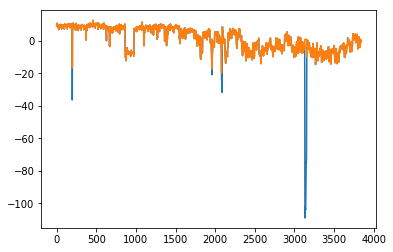

In [29]:
# clean and filter dataset

ndata, drop_these = clean_data(data,manver, reuse = True)
target = ndata['target']
plt.plot(target)

filtered_target = filter_target(target)

plt.plot(filtered_target)
plt.show()

In [30]:
ndata.shape

(3841, 64)

### Create and train model

In [31]:
X = np.array(ndata)[:,1:-1]
y = filtered_target
newX, newy = get_seq(X,y, n = 2)
x_train, x_test, y_train, y_test = train_test_split(newX,newy, test_size = 0.1, shuffle = False)

model = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 1))
model.fit(x_train,y_train)

print('R-Squared: ', r2_score(model.predict(x_test),y_test))

R-Squared:  0.9618010451947546


## Slow ineffective algorithm without correlation 

In [17]:
"""indexes = [13,16,19,21,23,24]
variables_range = []
for i in indexes:
    if i == 14:
        variables_range.append([-2,4])
    else:
        variables_range.append([np.mean(newX[:,i]) - 2*np.std(newX[:,i]),np.mean(newX[:,i]) + 2*np.std(newX[:,i])])
    
for data in x_test[:100]:
    best_solution = model.predict([data])
    var = data[indexes]
    for i,j in enumerate(indexes):
        if model.coef_[j] > 0:
            variables_range[i][0] = data[j]
        else:
            variables_range[i][1] = data[j]
    
    good_params = []
    good_params, best_solution = var_optimizer(variables_range, best_solution, var, data.copy(), model, good_params, indexes)"""

'indexes = [13,16,19,21,23,24]\nvariables_range = []\nfor i in indexes:\n    if i == 14:\n        variables_range.append([-2,4])\n    else:\n        variables_range.append([np.mean(newX[:,i]) - 2*np.std(newX[:,i]),np.mean(newX[:,i]) + 2*np.std(newX[:,i])])\n    \nfor data in x_test[:100]:\n    best_solution = model.predict([data])\n    var = data[indexes]\n    for i,j in enumerate(indexes):\n        if model.coef_[j] > 0:\n            variables_range[i][0] = data[j]\n        else:\n            variables_range[i][1] = data[j]\n    \n    good_params = []\n    good_params, best_solution = var_optimizer(variables_range, best_solution, var, data.copy(), model, good_params, indexes)'

In [18]:
indexes = [13,16,19,21,23,24]
variables_range = []
for i in indexes:
    if i == 14:
        variables_range.append([-2,4])
    else:
        variables_range.append([np.mean(newX[:,i]) - 2*np.std(newX[:,i]),np.mean(newX[:,i]) + 2*np.std(newX[:,i])])

constraint_variables_range = [
    [-19,13],
    [-18,13],
    [-20,13],
    [-20,16],
    [-20,14],
    [-16,12],
    [-15,11],
    [-12,10],
    [-17,20],
    [-18,16],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-np.inf,np.inf],
    [-3,5],
    [-np.inf,np.inf],
    [-2,4],
    [-np.inf,np.inf],
    [-2,4],
    [-5,4],
    [-16,21],
    [-11,17],
    [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
 [-np.inf,np.inf],
    
]

for data in x_test[:10]:
    best_solution = model.predict([data])
    good_params = []
    start_best = best_solution
    start_params = data[indexes]
    good_params, best_solution, res = greedy_optimizer(ndata, indexes, variables_range, constraint_variables_range, best_solution, data.copy(), model, good_params, net_len = 40)
    if len(good_params) != 0:
        print('Target Gain:', abs(best_solution - start_best) ,'\n'
              'Recomendation:', good_params, '\n\n')              

IndexError: list index out of range

In [9]:
def calculate_validation_data(validation_data,drop_these = drop_these, manver = manver, model= model, indexes = indexes, variables_range = variables_range, constraint_variables_range = constraint_variables_range):
    ndata = clean_data(validation_data,manver, drop_these= drop_these)
    target = ndata['target']
    filtered_target = filter_target(target)
    X_validation = np.array(ndata)[:,1:-1]
    y_validation = filtered_target
    X_validation, y_validation = get_seq(X_validation,y_validation, n = 2)
    print('R-Squared: ',r2_score(model.predict(X_validation),y_validation), end='\n\n')
    
    for data in X_validation:
        best_solution = model.predict([data])
        good_params = []
        start_best = best_solution
        start_params = data[indexes]
        good_params, best_solution, res = greedy_optimizer(ndata, indexes, variables_range, constraint_variables_range, best_solution, data.copy(), model, good_params, net_len = 40)
        if len(good_params) != 0:
            print('Target Gain:', abs(best_solution - start_best) ,'\n'
                  'Recomendation:', good_params, '\n\n') 

In [10]:
validation_data= pd.read_csv('data_for_MIPT_validation_2.csv')
calculate_validation_data(validation_data)

R-Squared:  0.8856358179268007
Target Gain: [2.74274165] 
Recomendation: [20.217390993906566 13.598580671670517 2.6094652775386638
 3.3370346689053574 5.769309903778009 2.628646050862584] 


Target Gain: [3.76636568] 
Recomendation: [19.452990347266685 9.610266577064273 3.776313004575086 3.1039177443571937
 5.769309903778009 2.775354892102121] 


Target Gain: [8.10830785] 
Recomendation: [16.98801197561112 3.979711163260827 4.005066621829818 2.8702060693592983
 4.713521509318983 2.707604061705235] 


Target Gain: [7.24426656] 
Recomendation: [18.37927926050722 6.677715746465087 4.096212546671414 1.7927952434635657
 6.232011686724346 2.93330925599432] 


Target Gain: [7.16499862] 
Recomendation: [16.64028682050435 1.2932167984698382 3.925192372202363 1.7927952434635657
 5.227556745003046 2.3127223608762577] 


Target Gain: [7.4891788] 
Recomendation: [15.92463816596869 3.1929342808723704 3.099404986555358 2.8702060693592983
 5.560947733436079 2.5471905261086416] 


Target Gain: [6.06138

Target Gain: [6.24788995] 
Recomendation: [-0.9057394129156529 -18.24795847492596 2.251103279416491
 6.819255089261496 5.769309903778009 3.657806695515517] 


Target Gain: [4.16402571] 
Recomendation: [9.091885654964273 -17.22108426284509 1.3179454265895447
 3.7022405170049146 3.6126283487727697 2.3466644339814184] 


Target Gain: [3.91882454] 
Recomendation: [-1.5940833356976924 -16.928158865304713 12.649306927104094
 -2.516848060119372 2.1511303286281573 2.762134369198366] 


Target Gain: [3.67060405] 
Recomendation: [10.472353236606954 -15.787314553971632 1.290703724726988
 -1.280469276701337 4.294577406283788 1.9689427317413337] 


Target Gain: [2.5185266] 
Recomendation: [17.03724599692926 -15.787314553971632 1.3690350545177994
 0.5035894170081826 4.529208969772931 2.889158861964142] 


Target Gain: [5.34385869] 
Recomendation: [18.154816591725886 6.364217447517669 -0.7568528284884866
 3.747510563108929 9.772595200499435 3.7016490968327567] 


Target Gain: [3.05611462] 
Recomendat

Target Gain: [3.35562871] 
Recomendation: [10.157026695765332 17.16320089210199 7.431991602208549 2.8702060693592983
 5.922122577571052 2.4650830285130136] 


Target Gain: [4.84379884] 
Recomendation: [11.282282665869674 16.46089909927191 5.317177733549865 3.9476168952550346
 5.655785620249912 2.2472864766510665] 


Target Gain: [4.39881914] 
Recomendation: [16.87322243025456 -5.955607231712277 6.890734499940523 1.7927952434635657
 3.4590955760087456 2.898398255915528] 


Target Gain: [1.09363883] 
Recomendation: [14.566602090182995 -15.787314553971632 3.0265191134615876
 0.9591759025802166 6.2509099379473625 2.4213458004089947] 


Target Gain: [2.4385516] 
Recomendation: [14.359871623365882 -15.787314553971632 3.2167215610161044
 1.8895897445753036 5.764682483651911 2.608971438350365] 


Target Gain: [4.52002333] 
Recomendation: [21.389105287207027 4.04443407851579 -0.6090217810373721 6.957725263415121
 6.549910626631053 3.7016490968327567] 


Target Gain: [3.18475922] 
Recomendation:

Target Gain: [1.96438004] 
Recomendation: [-0.8946514604181215 -17.849623076338762 2.172521479506212
 3.694620015172878 5.769309903778009 3.6415158419332583] 


Target Gain: [4.86241555] 
Recomendation: [-0.4581963552602383 -16.524763665079647 1.7255976647912914
 -0.3620264083279032 1.2710319826139735 2.0052733927068553] 


Target Gain: [4.80730615] 
Recomendation: [-1.074457349211292 -16.68425868276393 2.2592742502890975
 1.7927952434635657 2.2973524429301606 3.042540515232581] 


Target Gain: [3.7265115] 
Recomendation: [10.304817685962945 -13.8291644536777 5.494531752128921 5.825249847499853
 4.690969126275387 2.552797555317044] 


Target Gain: [7.17866685] 
Recomendation: [13.933160576247218 -12.223618989496984 4.7768090374457195
 1.7927952434635657 5.452525025220463 3.2478897668406663] 


Target Gain: [7.20516978] 
Recomendation: [16.390318333062474 -1.2524311263492298 2.8686717592760975
 1.7927952434635657 5.050807538014246 2.9596079799117714] 


Target Gain: [6.0965769] 
Recomen

Target Gain: [4.39879156] 
Recomendation: [10.64698372287706 17.358078479442824 0.5870226642902885
 2.8702060693592983 3.898061596840077 2.3586065708020607] 


Target Gain: [6.35659985] 
Recomendation: [22.37099521080427 14.793356332252626 -4.879693105918034 5.025027721150767
 4.147717122916606 2.3731800193900465] 


Target Gain: [2.44276272] 
Recomendation: [24.060575007787584 8.345465094013587 -7.557220105690673 5.568968688681721
 8.691943868707865 3.7016490968327567] 


Target Gain: [4.03334693] 
Recomendation: [18.797702890389314 4.259182991831561 -2.5232870481529335
 5.016436398973448 9.769188629025734 3.7016490968327567] 


Target Gain: [3.9623501] 
Recomendation: [21.926024789972377 -1.505613734245139 -0.22252236629451616
 3.6570533033368173 2.534287571270152 2.0745993495716712] 


Target Gain: [3.84269222] 
Recomendation: [10.710607281632214 -8.543226027894791 -1.2309192094602577
 5.823039814009911 3.0643890384031462 1.5409467830977412] 


Target Gain: [7.28566003] 
Recomendati